In [5]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My Drive/Sentime

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Sentime


In [0]:
data = pd.read_csv('2020_04_27_dataset.csv')
# test_data = pd.read_csv('2020_04_26_dataset.csv')

# data = data[data['sentiment'] != 'MIXED']

In [58]:
# preprocessing
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.utils import class_weight as cw

def clean_text(s):
  s = re.sub(r'pic.twitter\S+', '', s)
  s = re.sub(r'https?:\/\/.*[\r\n]*', '', s)
  s = re.sub(r'@[A-Za-z0-9]+', '', s)
  s = s.lower()
  return "".join([c for c in text if c != string.punctuation and c != '\n' and c != '\r']).strip()

# remove emojis
# data['tweet'] = data['tweet'].apply(lambda s: s.encode('ascii', 'ignore').decode('ascii'))
# test_data['tweet'] = test_data['tweet'].apply(lambda s: s.encode('ascii', 'ignore').decode('ascii'))

# data['tweet'].apply(clean_text)
# "".join([char for char in text if char != string.punctuation and char != '\n' and char != '\r']).strip()

stopwords = stopwords.words('spanish')
vectorizer = CountVectorizer(stop_words=stopwords)

X = vectorizer.fit_transform(data['tweet'])
Y = LabelEncoder()
Y = Y.fit_transform(data['sentiment'])
Y = to_categorical(Y)

print(data['sentiment'].value_counts())

y = y_train.flatten()
class_weight = cw.compute_class_weight('balanced', np.unique(y), y)

NEUTRAL     12381
POSITIVE     9959
NEGATIVE     6123
MIXED        2170
Name: sentiment, dtype: int64


In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['tweet'], Y, test_size=0.1)

max_words = len(set(" ".join(X_train).split()))
max_len = X_train.apply(lambda x: len(x)).max()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(27569,) (27569, 4)
(3064,) (3064, 4)


In [60]:
# Tokenize Text

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_len)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len)

print(X_train.shape, X_test.shape)

(27569, 289) (3064, 289)


In [63]:
from keras.models import Sequential
from keras.layers import Embedding, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, LSTM
from keras.optimizers import Adam

# Embedding
embed_dim = 100

# Convolution
filters = 1024
kernel_size = 3
pool_size = 2

# LSTM
lstm_output_size = 100
dropout = 0.5

num_classes = y_train.shape[1]

model = Sequential()
model.add(Embedding(max_words, embed_dim, input_length=max_len))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu',
                strides=1))
model.add(GlobalMaxPooling1D())

model.add(Dropout(dropout))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(2048, activation='relu'))

model.add(Dropout(dropout))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(num_classes, activation='softmax'))

#model = Sequential()
#model.add(Embedding(max_words, embed_dim, input_length=X_train.shape[1]))
#model.add(Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=pool_size))
#model.add(Conv1D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu'))
#model.add(MaxPooling1D(pool_size=pool_size))    
#model.add(LSTM(lstm_output_size, dropout=dropout, recurrent_dropout=dropout))
#model.add(Dense(num_classes, activation='softmax'))

learning_rate = 0.001
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 289, 100)          7049400   
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 287, 1024)         308224    
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 1024)              0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 1024)              0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_26 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 2048)            

In [64]:
# Training
epochs = 10
batch_size = 128
validation_split = 0.2

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    class_weight=class_weight
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22055 samples, validate on 5514 samples
Epoch 1/10
22055/22055 [==============================] - 8s 381us/step - loss: 1.8974 - accuracy: 0.3168 - val_loss: 1.2485 - val_accuracy: 0.4071
Epoch 2/10
22055/22055 [==============================] - 8s 363us/step - loss: 1.4070 - accuracy: 0.3472 - val_loss: 1.2470 - val_accuracy: 0.3760
Epoch 3/10
22055/22055 [==============================] - 8s 366us/step - loss: 1.3396 - accuracy: 0.3625 - val_loss: 1.2487 - val_accuracy: 0.3779
Epoch 4/10
22055/22055 [==============================] - 8s 364us/step - loss: 1.3143 - accuracy: 0.3789 - val_loss: 1.2552 - val_accuracy: 0.3983
Epoch 5/10
22055/22055 [==============================] - 8s 360us/step - loss: 1.2325 - accuracy: 0.4477 - val_loss: 1.3004 - val_accuracy: 0.3743
Epoch 6/10
22055/22055 [==============================] - 8s 358us/step - loss: 0.9793 - accuracy: 0.6017 - val_loss: 1.5289 - val_accuracy: 0.3500
Epoch 7/10
22055/22055 [==============================] - 8s 35

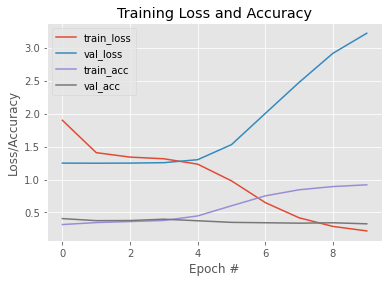

In [65]:
plt.style.use('ggplot')
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='best')

In [66]:
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

3064/3064 [==============================] - 0s 128us/step
Test score: 3.2592303360722394
Test accuracy: 0.3283289670944214


In [67]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

print("Saved model to disk")

Saved model to disk
